# UDLF Non-Local Means (LHRR)
Images and data collected from experiments of UDLF Non-Local Means with LHRR as the reranking method used.

## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

from skimage import data
from skimage.color import rgb2gray
from skimage.metrics import mean_squared_error as mse
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from skimage.restoration import estimate_sigma
from skimage.util import random_noise

from nlmeans.nlmeans import nlmeans
from nlmeans.nlmeans_udlf import nlmeans_udlf

## Parameters

In [2]:
# Non-Local Means parameters
hW = 10        # Window Size
hP = 3         # Patch Size
tau = 0.15     # Contribution of similarity on noisy-data
sig = 0.1      # Standard deviation of the gaussian noise
shape = 'disk' # Patch shape
n_w = None     # Number of weights to use or use all(None)

# Image to test with
image = 'astronaut'

# UDLF Parameters
udl_method = 'LHRR'
udl_params = {
    'k': 18,
    't': 2
}

## Image preprocessing
Get the image from skimage dataset or use the image from the local file system if not found in skimage. 

After that, do the necessary preprocessing:
- Crop the image to be 200x200 (This is necessary because UDLF has to be able to allocate memory to process the 
  ranked lists gotten from the image. In a system with more memory the image can possibly be greater);
- Convert the image from RGB to Grayscale.

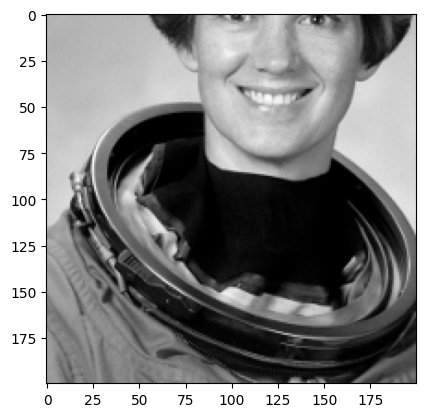

In [3]:
images = ('astronaut',
          'brick',
          'camera',
          'cat',
          'checkerboard',
          'clock',
          'coffee',
          'coins',
          'grass',
          'gravel',
          'horse')

if image in images:
    im = getattr(data, image)()
    im = im[100:300, 100:300]
    im_name = image
else:
    im = plt.imread(image).astype('float')
    im_name = os.path.splitext(os.path.basename(image))[0]

if len(im.shape) == 3:
    im = rgb2gray(im)

# Show the image
plt.imshow(im, cmap='gray')

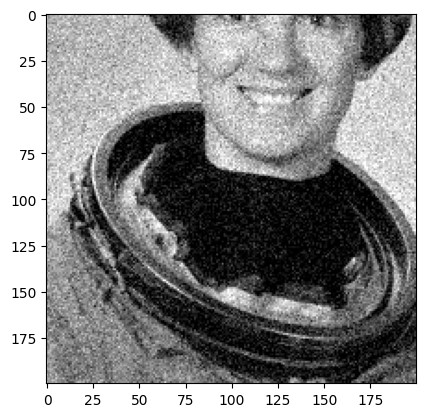

In [4]:
im_nse = random_noise(im, var = sig**2)
sigma_est = np.mean(estimate_sigma(im_nse, channel_axis=-1))
plt.imshow(im_nse, cmap='gray')

## Non-Local Means SAP
For comparison the Non-Local Means SAP (the algorithm on which UDLF Non-Local Means is based) is run as well. 

CPU times: user 1.64 s, sys: 4.47 ms, total: 1.64 s
Wall time: 1.64 s


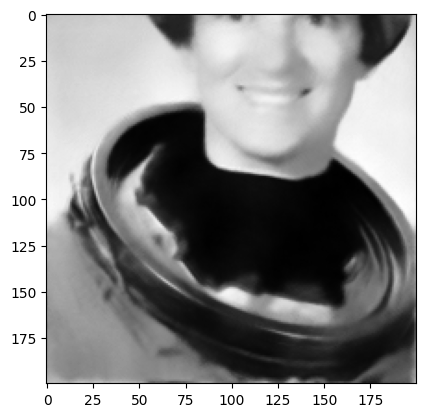

In [5]:
%%time
im_fil1 = nlmeans(im_nse, hW, hP, tau, sigma_est, shape)
plt.imshow(im_fil1, cmap='gray')

## UDLF Non-Local Means (LHRR)
This denoise the image using LHRR as the reranking method and considering RLRECOM default parameters as indicated in the [UDLF config.ini](https://github.com/UDLF/UDLF/blob/master/bin/config.ini)

CPU times: user 16.9 s, sys: 733 ms, total: 17.7 s
Wall time: 1min 14s


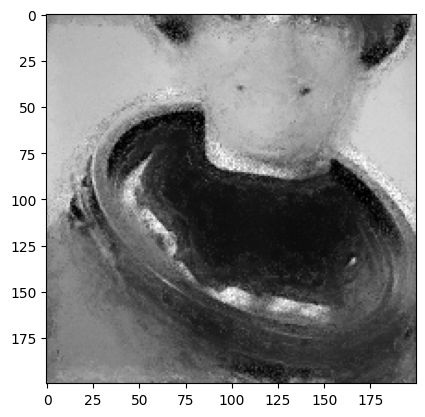

In [6]:
%%time
im_fil2 = nlmeans_udlf(im_nse, hW, hP, tau, sigma_est, shape, udl_method, udl_params, n_w)
plt.imshow(im_fil2, cmap='gray')

### Show the images side by side

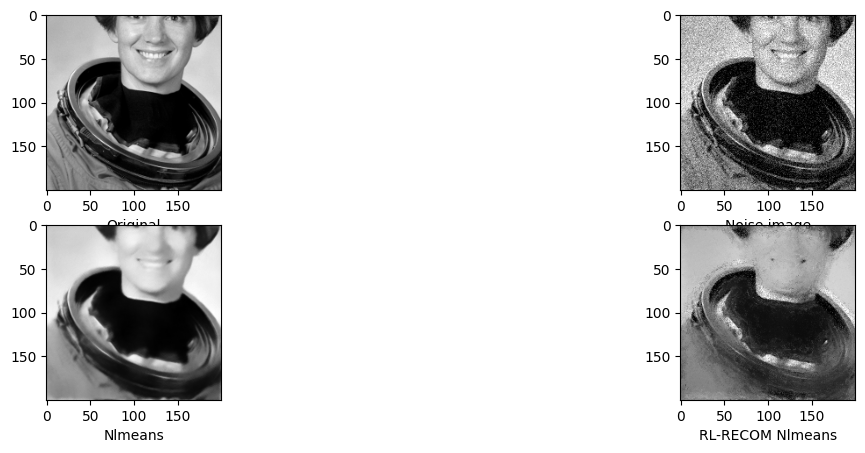

,Noise,Nlmeans,LHRR Nlmeans
PSNR,20.640589,22.875026,20.135896
SSIM,0.450158,0.669758,0.470659
MSE,0.008629,0.003643,0.009683


In [7]:
#plt.rcParams['figure.figsize'] = [15, 5]
plt.figure()
plt.subplot(2, 2, 1)
#plt.xlabel('Original')
plt.imshow(im, cmap='gray')
plt.subplot(2, 2, 2)
#plt.xlabel('Noise image')
plt.imshow(im_nse, cmap='gray')
plt.subplot(2, 2, 3)
#plt.xlabel('Nlmeans')
plt.imshow(im_fil1, cmap='gray')
plt.subplot(2, 2, 4)
#plt.xlabel('RL-RECOM Nlmeans')
plt.imshow(im_fil2, cmap='gray')
plt.show()

im_noise_psnr = psnr(im, im_nse, data_range=im_nse.max() - im_nse.min())
im_noise_ssim = ssim(im, im_nse, data_range=im_nse.max() - im_nse.min())
im_noise_mse  = mse(im, im_nse)

im_nlm_psnr   = psnr(im, im_fil1, data_range=im_fil1.max() - im_fil1.min())
im_nlm_ssim   = ssim(im, im_fil1, data_range=im_fil1.max() - im_fil1.min())
im_nlm_mse    = mse(im, im_fil1)

im_udlf_psnr  = psnr(im, im_fil2, data_range=im_fil2.max() - im_fil2.min())
im_udlf_ssim  = ssim(im, im_fil2, data_range=im_fil2.max() - im_fil2.min())
im_udlf_mse   = mse(im, im_fil2)

pd.DataFrame(
    data   = np.array([[im_noise_psnr, im_nlm_psnr, im_udlf_psnr],
                       [im_noise_ssim, im_nlm_ssim, im_udlf_ssim],
                       [im_noise_mse,  im_nlm_mse,  im_udlf_mse]]),
    index   = ['PSNR', 'SSIM', 'MSE'],
    columns = ['Noise', 'Nlmeans', 'LHRR Nlmeans'],
)

## Hyperparameters Tuning
The last experiment was runned using the default parameters which can be not the best. The next section tries to find the best value to each of the parameters accepted by the reranking method.

All the tests will be made considering PSNR as the value to be maximized.

In [8]:
%%time
# K parameter
# For speed porpuses only a subset of the values accepted by k will be tested (testing all the possible values for k
# could spend up to 80 hours).
start    = 3
end      = 20
step     = 1
possible_values = range(start, end, step)
iter_num = len(possible_values)
psnrs    = np.zeros(iter_num)
psnr_max = 0
best_k   = 0
best_im  = None

for i, k in enumerate(possible_values):
    udl_params['k'] = k
    try:
        im_fil3 = nlmeans_udlf(im_nse, hW, hP, tau, sigma_est, shape, udl_method, udl_params, n_w)
        psnr_value = psnr(im, im_fil3, data_range=im_fil3.max() - im_fil3.min())
        if psnr_value > psnr_max:
            psnr_max = psnr_value
            best_k   = k
            best_im  = im_fil3
        psnrs[i] = psnr_value
    except:
        print('Finished with error on param:', k)
        break
        
# Update method parameters
udl_params['k'] = best_k

CPU times: user 3min 17s, sys: 8.2 s, total: 3min 25s
Wall time: 17min 34s


params: {'k': 3, 't': 2}
PSNR: 22.495483680694303


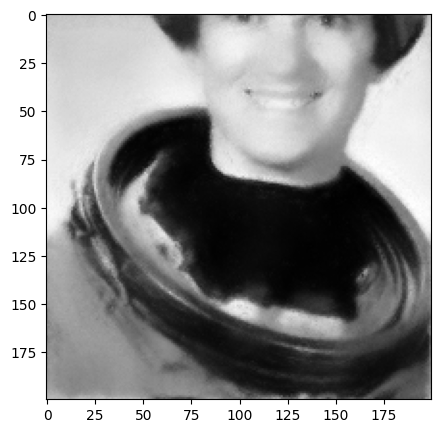

In [9]:
print('params:', udl_params)
print('PSNR:', psnr_max)
plt.imshow(best_im, cmap='gray')

Text(0, 0.5, 'PSNR')

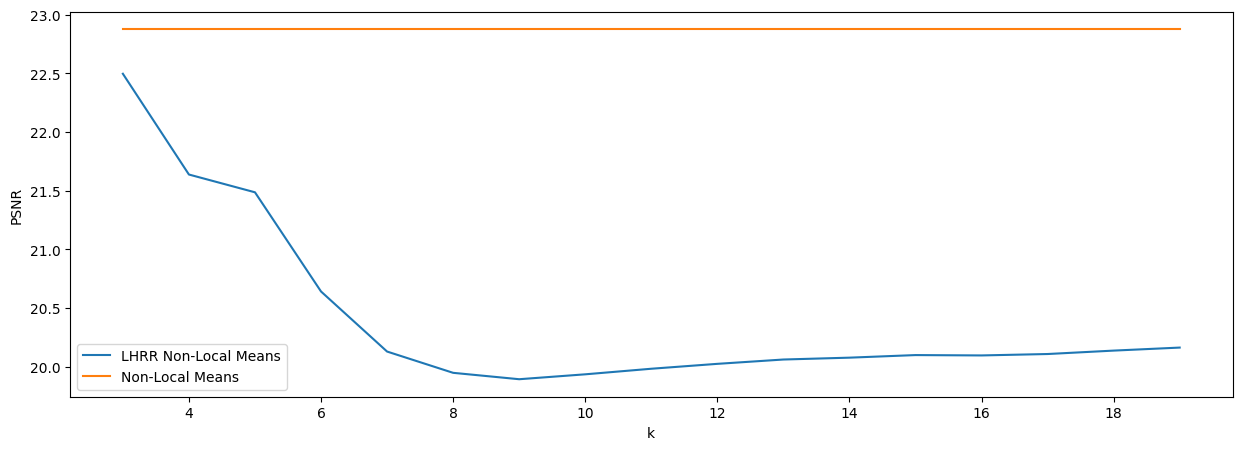

In [10]:
udlf_plot, = plt.plot(possible_values, psnrs, label = 'LHRR Non-Local Means')
nlm_plot,  = plt.plot(possible_values, [im_nlm_psnr] * iter_num, label = 'Non-Local Means')
plt.legend(handles = [udlf_plot, nlm_plot])
plt.xlabel('k')
plt.ylabel('PSNR')

### t

In [14]:
%%time
start    = 1
end      = 5
step     = 1
possible_values = range(start, end, step)
iter_num = len(possible_values)
psnrs    = np.zeros(iter_num)
best_t   = 0


for i, t in enumerate(possible_values):
    udl_params['t'] = t
    try:
        im_fil3 = nlmeans_udlf(im_nse, hW, hP, tau, sigma_est, shape, udl_method, udl_params, n_w)
        psnr_value = psnr(im, im_fil3, data_range=im_fil3.max() - im_fil3.min())
        if psnr_value > psnr_max:
            psnr_max = psnr_value
            best_t   = t
            best_im  = im_fil3
        psnrs[i] = psnr_value
    except:
        print('Finished with error on param:', k)
        break
        
# Update method parameters
udl_params['t'] = best_t

CPU times: user 1min 3s, sys: 2.73 s, total: 1min 6s
Wall time: 2min 36s


params: {'k': 3, 't': 0}
PSNR: 22.72268535310255


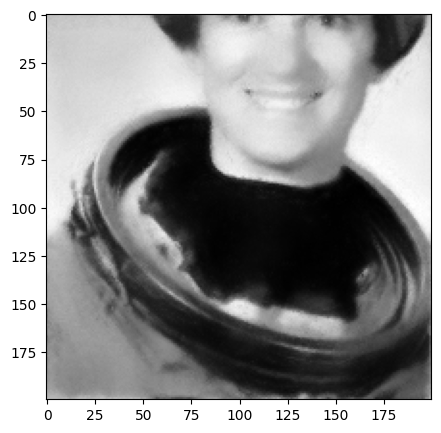

In [15]:
print('params:', udl_params)
print('PSNR:', psnr_max)
plt.imshow(best_im, cmap='gray')

Text(0, 0.5, 'PSNR')

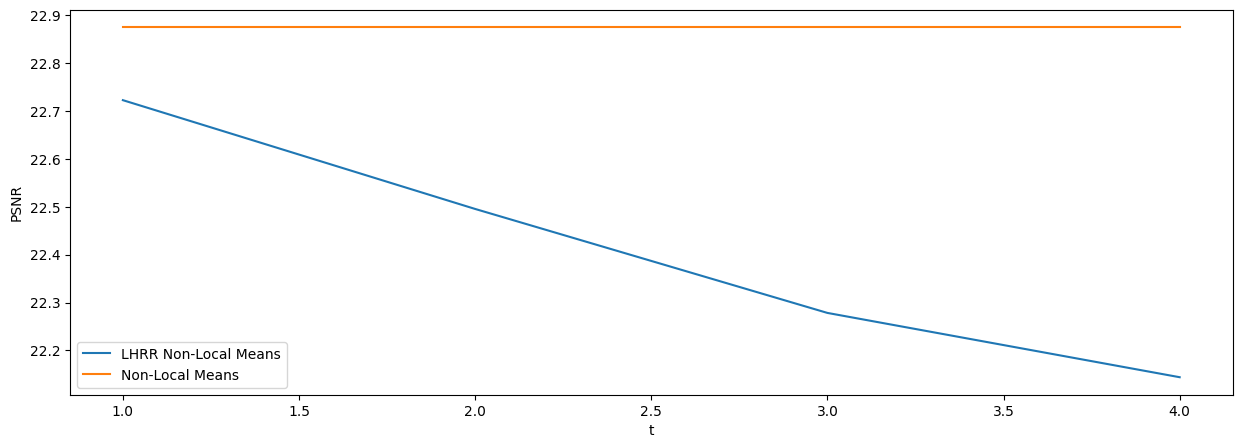

In [16]:
udlf_plot, = plt.plot(possible_values, psnrs, label = 'LHRR Non-Local Means')
nlm_plot,  = plt.plot(possible_values, [im_nlm_psnr] * iter_num, label = 'Non-Local Means')
plt.legend(handles = [udlf_plot, nlm_plot])
plt.xlabel('t')
plt.ylabel('PSNR')